In this notebook I will use fastai vision models in order to get an image classifier with high accuracy and try it on a Zindi competition.
Here's the fastai vision documentation for multi-class image classification:
https://docs.fast.ai/tutorial.vision#Multi-label-classification---Using-the-high-level-API
and here's the link of the Zindi competition:
https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge

# Dataset dowload from Zindi 

To get the images folder from zindi plateform directly on google colab

In [1]:
import requests
import requests, zipfile

#the url and auth_value from the website 
url = 'https://api.zindi.africa/v1/competitions/cgiar-wheat-growth-stage-challenge/files/Images.zip'
myobj = {'auth_token': 'iFaaLD3mkwWE3qwdegPX5MRa'} #use your own

x = requests.post(url, data = myobj,stream=True)
target_path = 'Images.zip'

handle = open(target_path, "wb")
for chunk in x.iter_content(chunk_size=512):
    if chunk:  # filter out keep-alive new chunks
        handle.write(chunk)
handle.close()

!unzip -qq Images.zip

# Prepare dataset + some data augmentation

In [2]:
# import Libraries
import random
import os
import gc
import random
random.seed(3)
import pandas as pd
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 194kB 4.6MB/s 


In [3]:
# Read in the train csv
train = pd.read_csv('Train.csv')
train.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1


In [4]:
# Use only high quality images 
train_hq = train[train['label_quality']== 2]
train_hq.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
7,sYLqmiXV,3,2


In [5]:
# View the high quality dataframe to see if all growth stages are present within the high quality training csv
train_hq.growth_stage.unique()

array([4, 3, 7, 2, 5])

In [6]:
# How many images are of high quality
print("The number of images with hgh quality are:", train[train['label_quality']== 2].shape[0])

The number of images with hgh quality are: 2856


In [7]:
# Image Augmentation used for Resnet50 and lr_max = slice (3e-6) with 40 epochs
tfms = setup_aug_tfms([Rotate(max_deg=25, p=1.),
            RandomResizedCrop(p=1., size=256),
            Brightness(max_lighting=1.0, p=0.4),
            CropPad(size=256),
            Zoom(max_zoom=1.0, p=0.2),
            Warp(magnitude=0.2, p=0.2)
            ])

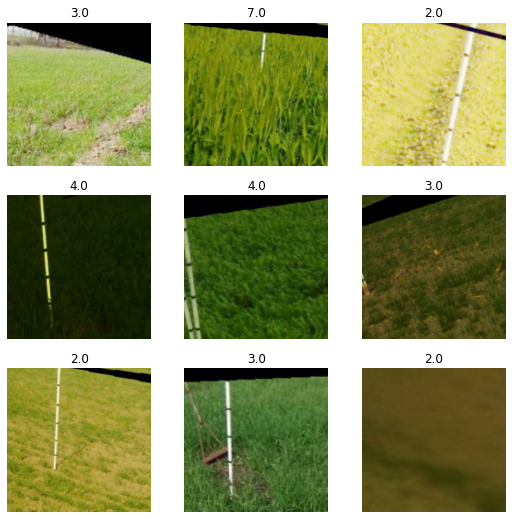

In [8]:
# Create our dataloaders
dls = ImageDataLoaders.from_df(train_hq, # train_hq if you only want the smaller high-quality set of images
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms) #The only other change!
dls.show_batch()

In [9]:
# Training the model
learn = cnn_learner(dls, resnet50, metrics=rmse, pretrained=True).to_fp16()
learn.fine_tune(200)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,_rmse,time
0,18.448782,9.909420,3.147923,00:16


epoch,train_loss,valid_loss,_rmse,time
0,13.043296,8.699222,2.949445,00:16
1,11.896666,9.669250,3.109542,00:16
2,11.193993,7.837231,2.799506,00:16
3,10.220427,6.882015,2.623360,00:16
4,9.261211,5.514853,2.348373,00:16
5,8.278844,4.989369,2.233690,00:16
6,7.492343,4.050737,2.012644,00:16
7,6.425771,2.683677,1.638193,00:16
8,5.776288,2.420244,1.555713,00:16
9,5.049234,1.830207,1.352851,00:16


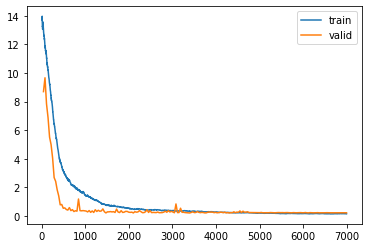

In [10]:
learn.recorder.plot_loss()

In [11]:
learn.fit_one_cycle(100, lr_max=slice(10e-8, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.151977,0.220088,0.469135,00:16
1,0.152466,0.219915,0.468951,00:16
2,0.161083,0.217157,0.466002,00:15
3,0.155229,0.221947,0.471113,00:16
4,0.154909,0.220373,0.469439,00:16
5,0.160475,0.219538,0.468549,00:16
6,0.157817,0.225558,0.474930,00:16
7,0.159042,0.224267,0.473569,00:16
8,0.154645,0.217296,0.466150,00:16
9,0.155722,0.220508,0.469583,00:16


# Make predictions on the test samples

In [12]:
# Making test dataloader and Test Time Augementation
ss = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [13]:
# Making Submission
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier

In [14]:
ss.to_csv('submission__zindi_2.csv', index=False)

In [15]:
ss.head(2)

,UID,growth_stage
0,F3LbWkZq,3.938599
1,6P4wLVzI,3.853149
